# 2 Image Stitching

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def print_images(list_of_images):
    fig, ax = plt.subplots(1, len(list_of_images), figsize=(20,20))
    for i, (img,name) in enumerate(list_of_images):
        ax[i].set_title(str(name))
        ax[i].imshow(img);

In [3]:
path_to_data = "data/"
file_1 = "1Hill.JPG"
file_2 = "2Hill.JPG"
file_3 = "3Hill.JPG"

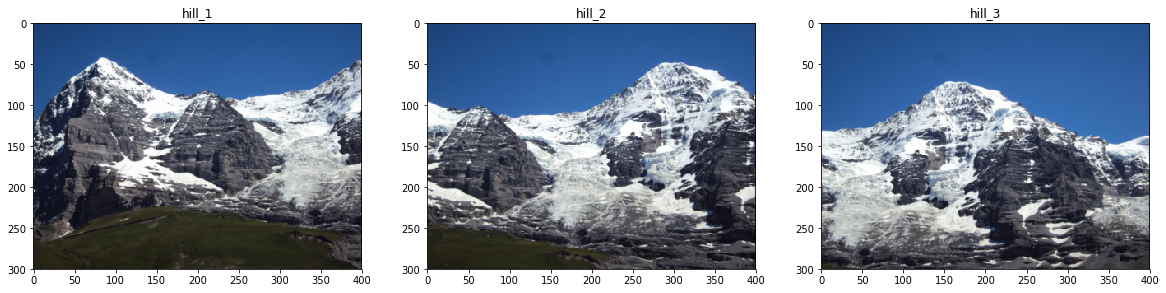

In [4]:
# import imgs
hill_1 = cv2.imread(path_to_data + file_1)
hill_2 = cv2.imread(path_to_data + file_2)
hill_3 = cv2.imread(path_to_data + file_3)

# convert to RGB
hill_1 = cv2.cvtColor(hill_1, cv2.COLOR_BGR2RGB)
hill_2 = cv2.cvtColor(hill_2, cv2.COLOR_BGR2RGB)
hill_3 = cv2.cvtColor(hill_3, cv2.COLOR_BGR2RGB)

# plot images
print_images([(hill_1, "hill_1"), (hill_2, "hill_2"), (hill_3, "hill_3")])

## 2.1 PART 1

### 2.1.1 
Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill. (3 points)

In [5]:
# sift object 
sift = cv2.xfeatures2d.SIFT_create()

# compute SIFT keypoints & descriptor
keypoints_hill_1, descriptors_hill_1 = sift.detectAndCompute(hill_1, None)
keypoints_hill_2, descriptors_hill_2 = sift.detectAndCompute(hill_2, None)

### 2.1.2
Find matching keypoints in two images and display the 20 best pairs. (4 points)

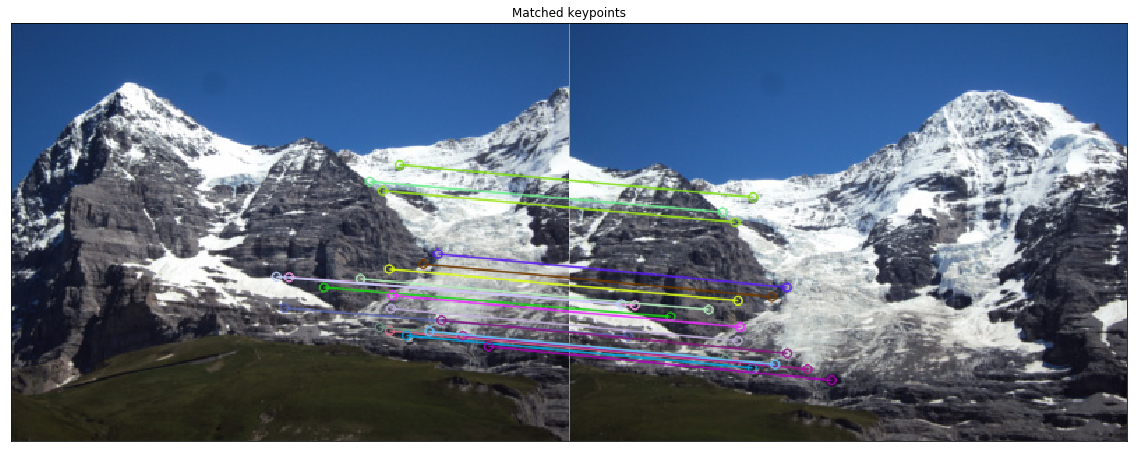

In [6]:
# Match descriptors and keep only best 20
def get_n_best_matches(n, descriptors_1, descriptors_2):
    bf = cv2.BFMatcher()
    matches = bf.match(descriptors_1, descriptors_2)
    return sorted(matches, key = lambda x:x.distance)[:n]

matches = get_n_best_matches(20, descriptors_hill_1, descriptors_hill_2)

# Draw keypoints and plot
match_img = cv2.drawMatches(hill_1, keypoints_hill_1,
                            hill_2, keypoints_hill_2,
                            matches, hill_1, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(match_img)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.3
Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed. (7 points)

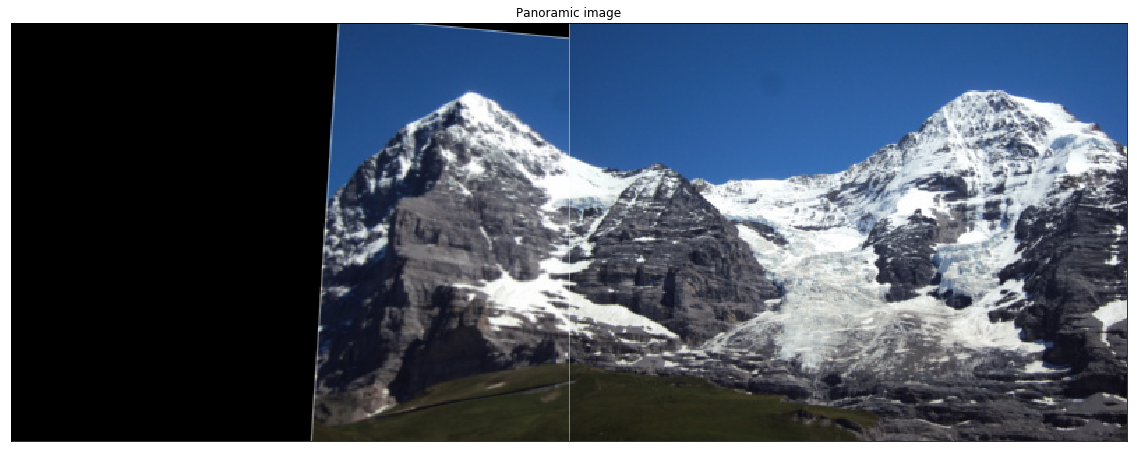

In [7]:
def get_good_matches(ms, kpts_1, kpts_2, img_2):
    # Arrange matching keypoints in two separate lists
    GoodMatches = []
    for i, m in enumerate(ms):
        GoodMatches.append((m.trainIdx, m.queryIdx))

    mp_2 = np.float32([kpts_2[i].pt for (i, __) in GoodMatches])
    mp_1 = np.float32([kpts_1[i].pt for (__, i) in GoodMatches])

    # shift points towards the right
    for i in range(len(mp_2)):
        mp_2[i][0] += img_2.shape[1]
        
    return mp_2, mp_1
    
def get_transformation_ransac(img_1, img_2, mp_1, mp_2):
    # find homography and wrap image accordingly
    H, __ = cv2.findHomography(mp_1, mp_2, cv2.RANSAC, 5)
    img = cv2.warpPerspective(img_1, H, (img_2.shape[1]+img_1.shape[1], img_2.shape[0]))
    img[:,img_2.shape[1]:,:] = img_2
    return img

mpr, mpl = get_good_matches(matches, keypoints_hill_1, keypoints_hill_2, hill_2)
pano = get_transformation_ransac(hill_1, hill_2, mpl, mpr)

plt.figure(figsize=(20,20))
plt.imshow(pano)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.4
Stitch transformed 1Hill and original 2Hill together using pyramid image blending. (8 points)

In [8]:
def get_gaussian_pyramid(img, d):
    cp = img.copy()
    pyramid = [cp]
    for i in range(d):
        cp = cv2.pyrDown(cp)
        pyramid.append(cp)
    return pyramid


def get_laplacian_pyramid(img, d):
    lp = [img[d-1]]
    for i in range(d-1,0,-1):
        hA, wA, cA = img[i-1].shape
        hr = cv2.pyrUp(img[i], dstsize=(wA, hA))
        lp_ = cv2.subtract(img[i-1], hr, cv2.CV_32F)
        lp.append(lp_)
    return lp


def get_transformation_pyramid(A, B, g_size, depth):
    # generate Gaussian pyramid for A and B.
    gp_A, gp_B = get_gaussian_pyramid(A, g_size), get_gaussian_pyramid(B, g_size)

    # generate Laplacian Pyramid for A and B.
    lp_A, lp_B = get_laplacian_pyramid(gp_A, depth), get_laplacian_pyramid(gp_B, depth)

    # Stack images together at each Laplacian Pyramid level.
    LP = []
    for l_a,l_b in zip(lp_A,lp_B):
        lp_ = np.hstack((l_a,l_b))
        LP.append(lp_)

    # Blend and reconstruct the final image.
    rs_mask = LP[0]
    for i in range(1,depth):
        h, w, c = LP[i].shape
        rs_mask = cv2.pyrUp(rs_mask, dstsize=(w, h))
        rs_mask = cv2.add(rs_mask, LP[i])
    
    return rs_mask

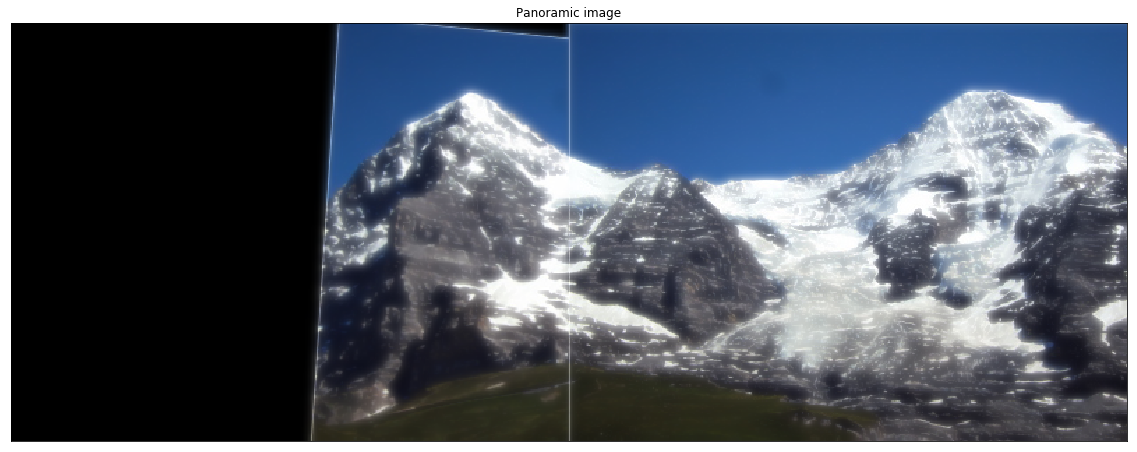

In [9]:
img_left = pano[:, :int(pano.shape[1]/2)]
hill_12 = get_transformation_pyramid(img_left, hill_2, 255 ,3)


plt.figure(figsize=(20,20))
plt.imshow(hill_12)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.1 PART 2

### 2.2.1
Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill. (3 points)

(Text(0.5,1,'SURF Features'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

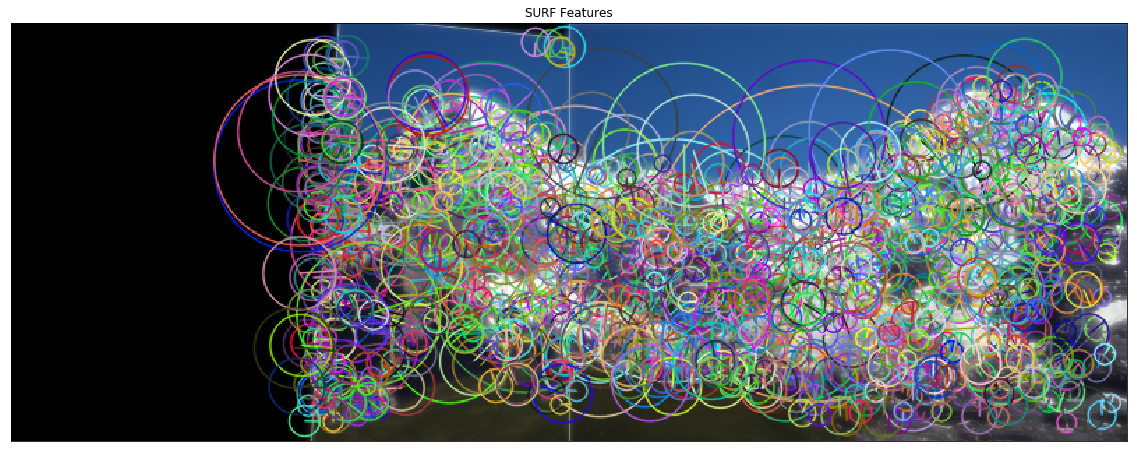

In [11]:
hill_12_cp = hill_12.copy()
# convert to grayscale
hill_12_grey = cv2.cvtColor(hill_12, cv2.COLOR_BGR2GRAY)

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# get keypoitns and descriptors
keypoints_hill_12, descriptors_hill_12 = surf.detectAndCompute(hill_12_grey, None)

# draw keypoints on hill_12_cp
cv2.drawKeypoints(hill_12, keypoints_hill_12,
                  hill_12_cp,
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# plot images
plt.figure(figsize=(20,20))
plt.imshow(hill_12_cp)
plt.title("SURF Features"), plt.xticks([]), plt.yticks([])

### 2.2.2 
Find matching keypoints in two images and display the 20 best pairs. (4 points)

### 2.2.3
Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed. (7 points)

### 2.2.4
Stitch transformed 3Hill and 12Hill together and apply linear image blending. (4 points)